# IMPORTS

In [3]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import datetime
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.cross_validation import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold


/Users/djurk/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/djurk/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
accidents = pd.read_csv('numeric_accidents.csv')

/Users/djurk/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## In this notebook, we'll be modelling.

### Looking at only accidents in Birmingham with the numeric dataset created earlier.  We will be attempting some ARIMA time series modelling

In [6]:
birmingham = accidents[accidents['Local_Authority_(District)'] == 300]

In [7]:
birmingham[birmingham['Date']=='02/02/2012']

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year,Month,Hour,count
102334,201220T006652,-1.881866,52.429232,20,3,2,2,02/02/2012,5,15:30,300,E08000025,3,4040,1,30,6,0,0.0,0.0,1,1.0,1.0,0.0,0.0,1,1.0,E01008932,2012,2,15,1
102970,201220W008182,-1.856415,52.476672,20,3,1,1,02/02/2012,5,13:40,300,E08000025,4,4128,6,30,4,4145,0.0,5.0,1,9.0,1.0,0.0,0.0,1,0.0,E01009198,2012,2,13,1


In [311]:
birmingham['Weather_Conditions'].value_counts()

1.0    20690
2.0     3514
8.0     1520
9.0     1092
5.0      288
4.0      288
3.0      198
7.0       68
6.0       17
Name: Weather_Conditions, dtype: int64

In [8]:
birmingham = birmingham.drop(['Accident_Index','Longitude','Latitude','Police_Force','Local_Authority_(Highway)',
            '1st_Road_Class','1st_Road_Number','2nd_Road_Class',
            '2nd_Road_Number','Pedestrian_Crossing-Human_Control','Pedestrian_Crossing-Physical_Facilities',
            'Special_Conditions_at_Site','Carriageway_Hazards','Did_Police_Officer_Attend_Scene_of_Accident',
            'LSOA_of_Accident_Location', 'Accident_Severity','Number_of_Vehicles','Number_of_Casualties',
            'Road_Type','Urban_or_Rural_Area','count'], axis = 1)

In [9]:
birminghamtime = birmingham.groupby(['Date']).count().reset_index()

In [10]:
birminghamtime.head()

,Date,Day_of_Week,Time,Local_Authority_(District),Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Year,Month,Hour
0,01/01/2005,8,8,8,8,8,8,8,8,8,8
1,01/01/2006,8,8,8,8,8,8,8,8,8,8
2,01/01/2007,13,13,13,13,13,13,13,13,13,13
3,01/01/2009,8,8,8,8,8,8,8,8,8,8
4,01/01/2010,9,9,9,9,9,9,9,9,9,9


In [11]:
birminghamtime = birminghamtime[['Date','Day_of_Week']]
birminghamtime = birminghamtime.rename({'Day_of_Week':'Number_of_Accidents'}, axis = 1)

In [12]:
birminghamtime['Date'] = pd.to_datetime(birminghamtime['Date'])

birminghamtime = birminghamtime.sort_values(by='Date')

birminghamts = birminghamtime.set_index('Date')

### Now we have the counts of accidents for each day.

In [194]:
birminghamts

,Number_of_Accidents
Date,
2005-01-01,8
2005-01-02,16
2005-01-03,12
2005-01-04,3
2005-01-05,12
2005-01-06,13
2005-01-07,12
2005-01-08,11
2005-01-09,8


In [195]:
birminghamts.describe()

,Number_of_Accidents
count,3278.000000
mean,8.442648
std,3.815181
min,1.000000
25%,6.000000
50%,8.000000
75%,11.000000
max,27.000000


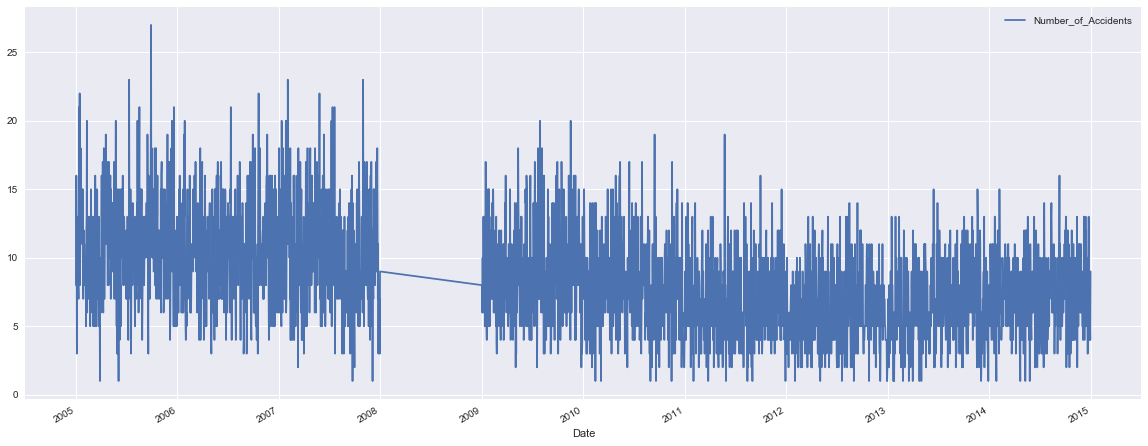

In [13]:
#The dataset was missing data from 2008, so we'll be creating a time series from 2009 onward.
birminghamts.plot(figsize = (20,8))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e736c88>]], dtype=object)

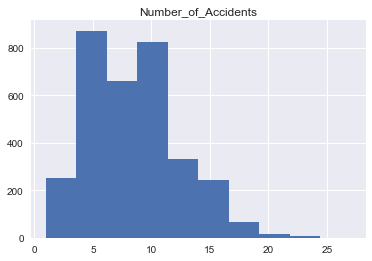

In [197]:
birminghamts.hist()


In [14]:
birminghamts9 = birminghamts['2009':'2014']

In [15]:
birminghamts9

,Number_of_Accidents
Date,
2009-01-01,8
2009-01-02,6
2009-01-03,10
2009-01-04,7
2009-01-05,6
2009-01-06,13
2009-01-07,8
2009-01-08,9
2009-01-09,7


In [230]:
#some days are missing from this dataframe because there were no accidents on some days.
birminghamts9[360:365]

,Number_of_Accidents
Date,
2009-12-29,13
2009-12-30,7
2009-12-31,7
2010-01-01,9
2010-01-02,12


### fixing missing dates

In [16]:
reset = birminghamts9.reset_index()

In [17]:
reset.head()

,Date,Number_of_Accidents
0,2009-01-01,8
1,2009-01-02,6
2,2009-01-03,10
3,2009-01-04,7
4,2009-01-05,6


In [18]:
reset.loc[363]

Date                   2010-01-01 00:00:00
Number_of_Accidents                      9
Name: 363, dtype: object

In [19]:
prev_date = reset.Date[0]
fill = []
for i, row in reset.iterrows():
    if row.Date != prev_date + datetime.timedelta(days=1):
        print(row.Date)
        fill.append(row.Date - datetime.timedelta(days=1))
    prev_date = row.Date

2009-01-01 00:00:00
2009-03-03 00:00:00
2009-07-27 00:00:00
2011-01-28 00:00:00
2012-04-12 00:00:00
2012-06-18 00:00:00
2013-09-07 00:00:00
2014-05-31 00:00:00
2014-11-30 00:00:00


In [20]:
fill

[Timestamp('2008-12-31 00:00:00'),
 Timestamp('2009-03-02 00:00:00'),
 Timestamp('2009-07-26 00:00:00'),
 Timestamp('2011-01-27 00:00:00'),
 Timestamp('2012-04-11 00:00:00'),
 Timestamp('2012-06-17 00:00:00'),
 Timestamp('2013-09-06 00:00:00'),
 Timestamp('2014-05-30 00:00:00'),
 Timestamp('2014-11-29 00:00:00')]

In [21]:
filldf = pd.DataFrame(fill)
filldf['Number_of_Accidents'] = 0

filldf = filldf.rename({0:'Date'}, axis = 1)

filldf = filldf.drop(index=0)

In [22]:
reset2 = reset.append(filldf)

In [23]:
reset2 = reset2.sort_values('Date')

In [24]:
birminghamts9 = reset2.set_index('Date')

### fixed

In [25]:
len(birminghamts9)

2191

In [26]:
#series
accident_series = pd.Series(birminghamts9['Number_of_Accidents'])

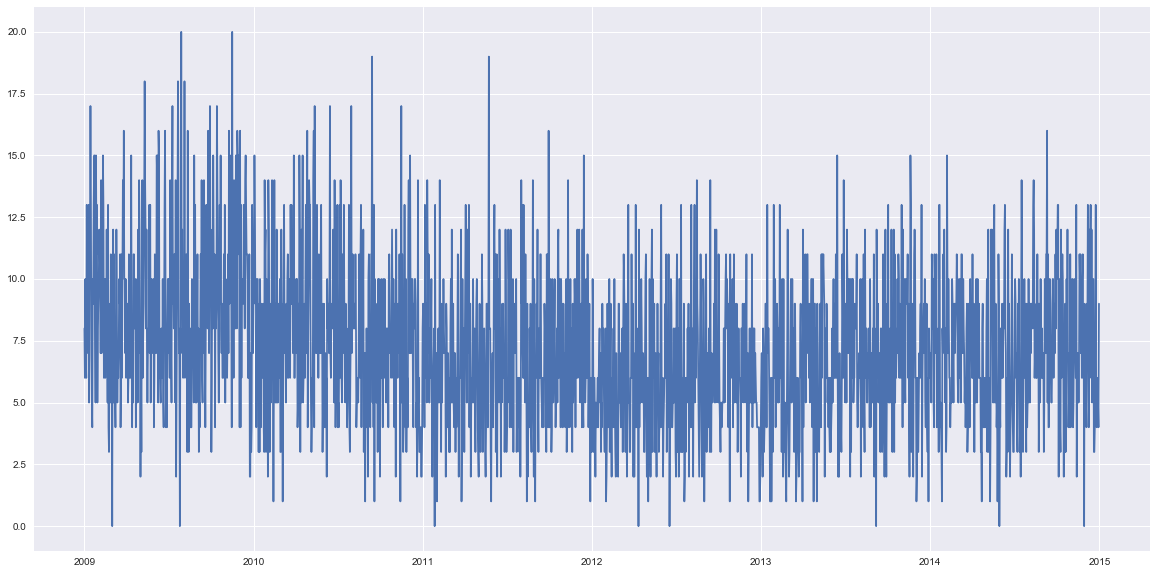

In [27]:
plt.figure(figsize = (20,10))
plt.plot(accident_series)

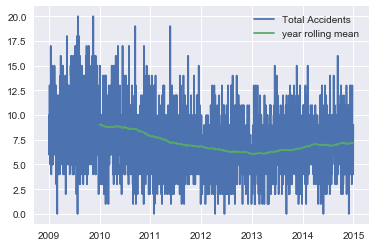

In [321]:
rolling_mean = accident_series.rolling(window=365).mean()

plt.plot(accident_series)
plt.plot(rolling_mean)
plt.legend(['Total Accidents','year rolling mean'])

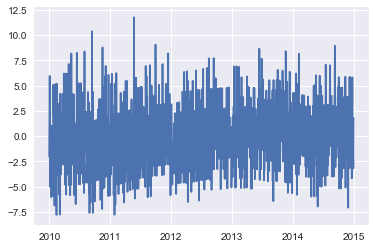

In [322]:
#Detrending the series
detrended_series = (accident_series) - (rolling_mean).dropna()
plt.plot(detrended_series)

In [360]:
#Dicky fuller test
result = adfuller(accident_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.793784
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


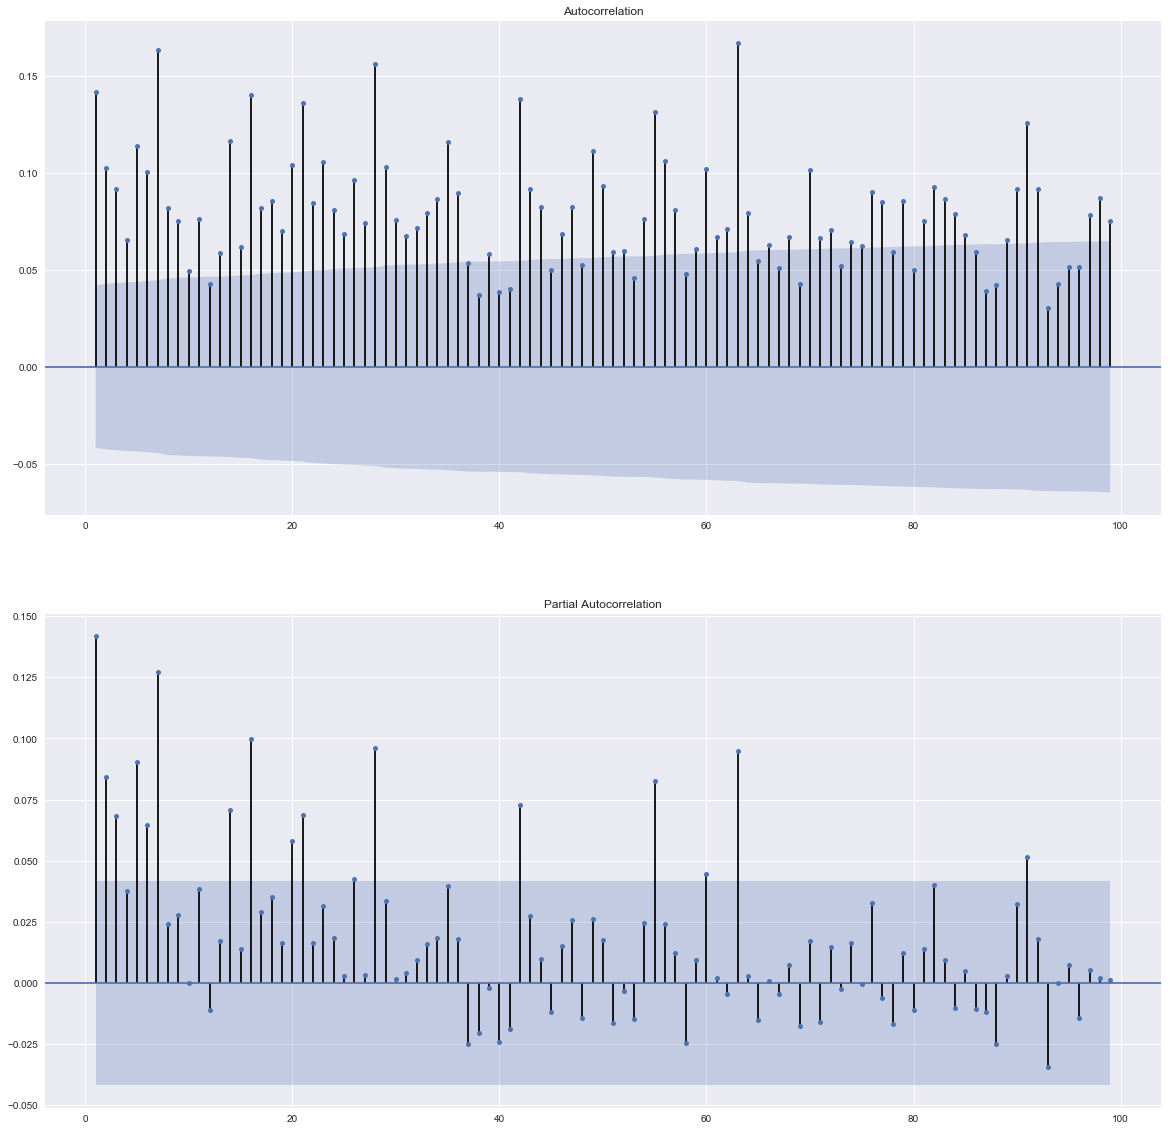

In [365]:
#ACF and PACF plots to get p,q values
plt.figure(figsize = (20,20))
plt.subplot(211)
plot_acf(accident_series, ax=plt.gca(), lags = np.arange(1,100))
plt.subplot(212)
plot_pacf(accident_series, ax=plt.gca(), lags = np.arange(1,100))
plt.show()

### the ACF and PACF plots are extremely hard to read here, lets try with some differencing

In [383]:
def difference(dataset, interval = 1):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

In [352]:
stationary = difference(accident_series)

stationary.index = accident_series.index[1:]

In [368]:
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.512304
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


#### The dicky fuller test shows the data as much more stationary now.

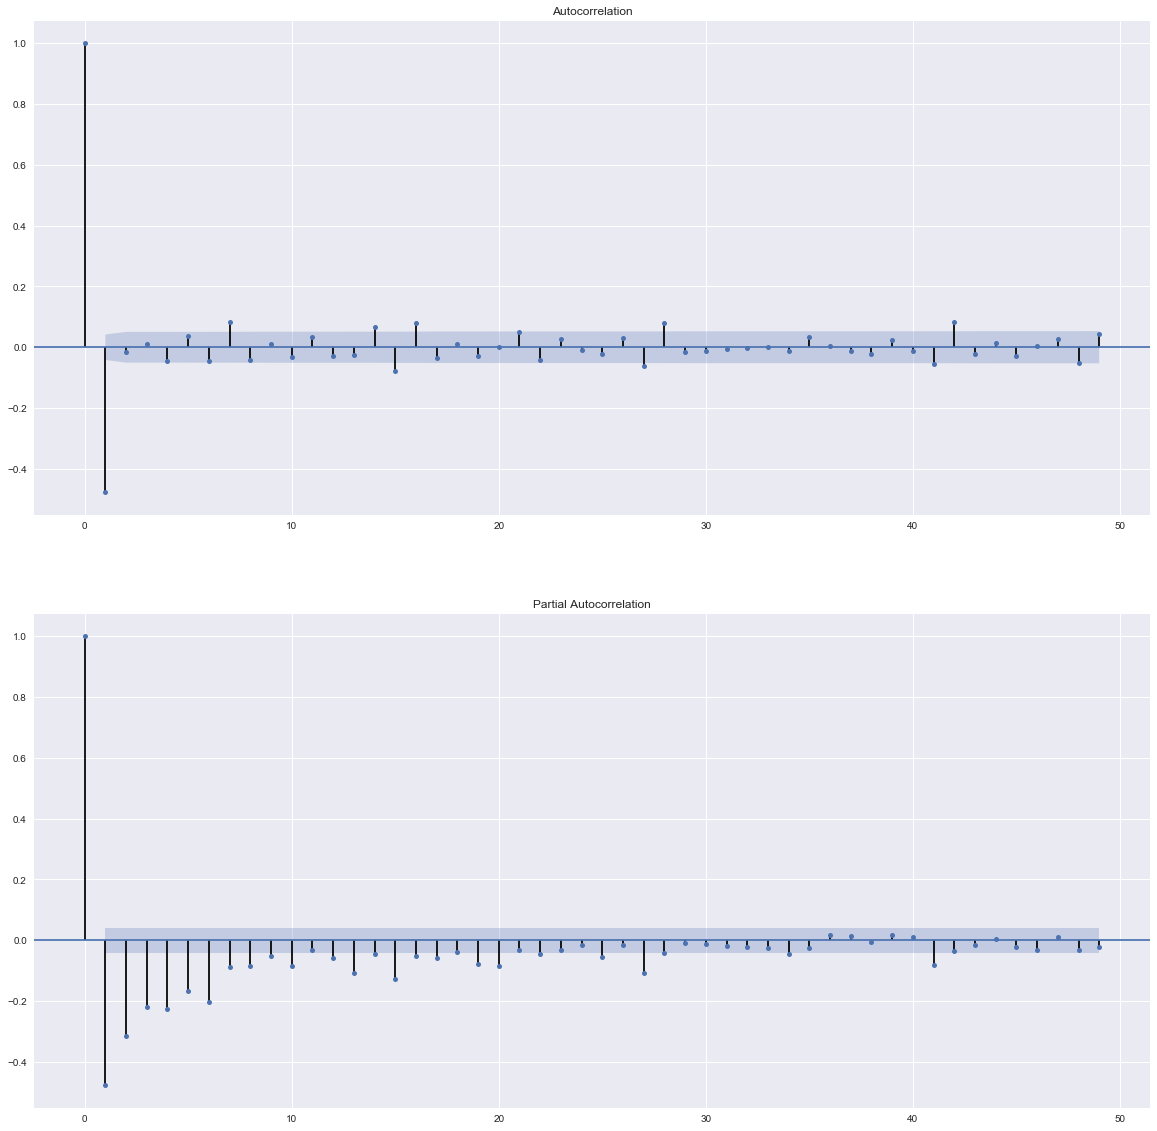

In [369]:
#diff
plt.figure(figsize = (20,20))
plt.subplot(211)
plot_acf(stationary, ax=plt.gca(), lags = np.arange(0,50))
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca(), lags = np.arange(0,50))
plt.show()

In [ ]:
(2,1,0)

In [380]:
stationary = stationary.astype('float')

In [752]:
accident_series = accident_series.astype('float')

In [ ]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [444]:
len(train)

2184

RMSE: 3.764


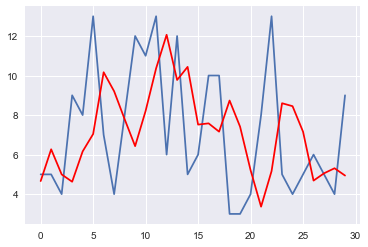

In [760]:
X = accident_series.values
train, test = X[0:(len(X)-30)], X[(len(X)-30):len(X)]
history = [x for x in train]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order = (2,1,0))
    model_fit = model.fit(disp = 0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%3.f, Expected=%3.f' % (yhat, obs))

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [761]:
r2_score(test,predictions)

-0.39216787723092605

In [1]:
#Our time series did horribly.  Let's see if facebook's Prophet can do any better!

In [5]:
from fbprophet import Prophet

In [28]:
accident_series

Date
2009-01-01     8
2009-01-02     6
2009-01-03    10
2009-01-04     7
2009-01-05     6
2009-01-06    13
2009-01-07     8
2009-01-08     9
2009-01-09     7
2009-01-10    13
2009-01-11     5
2009-01-12    11
2009-01-13    12
2009-01-14    17
2009-01-15    13
2009-01-16     7
2009-01-17     5
2009-01-18     4
2009-01-19    10
2009-01-20     9
2009-01-21    13
2009-01-22    15
2009-01-23    15
2009-01-24     8
2009-01-25     5
2009-01-26    15
2009-01-27    11
2009-01-28    13
2009-01-29     5
2009-01-30     8
2009-01-31     9
2009-02-01    10
2009-02-02    12
2009-02-03    11
2009-02-04    10
2009-02-05     7
2009-02-06    14
2009-02-07     7
2009-02-08     8
2009-02-09    10
2009-02-10    15
2009-02-11    13
2009-02-12     6
2009-02-13    10
2009-02-14    10
2009-02-15     6
2009-02-16    10
2009-02-17     8
2009-02-18    12
2009-02-19     8
2009-02-20     5
2009-02-21    13
2009-02-22     4
2009-02-23     3
2009-02-24     7
2009-02-25     9
2009-02-26     5
2009-02-27    11
2009-02-2

In [29]:
reset = accident_series.reset_index()

In [30]:
reset.columns = ['ds','y']

In [31]:
reset.head()

,ds,y
0,2009-01-01,8
1,2009-01-02,6
2,2009-01-03,10
3,2009-01-04,7
4,2009-01-05,6


In [32]:
promodel = Prophet()
promodel.fit(reset[0:(len(reset) - 30)])

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [33]:
future_python = promodel.make_future_dataframe(periods=30)

In [34]:

forecast_python = promodel.predict(future_python)

In [35]:
forecast_python.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2009-01-01,9.430103,9.430103,9.430103,4.862407,12.594953,-0.761838,-0.761838,-0.761838,-0.761838,-0.761838,-0.761838,0.126458,0.126458,0.126458,-0.888296,-0.888296,-0.888296,8.668265
1,2009-01-02,9.427281,9.427281,9.427281,4.836682,12.539571,-0.568389,-0.568389,-0.568389,-0.568389,-0.568389,-0.568389,0.288374,0.288374,0.288374,-0.856763,-0.856763,-0.856763,8.858891
2,2009-01-03,9.424458,9.424458,9.424458,4.323523,12.178388,-1.202495,-1.202495,-1.202495,-1.202495,-1.202495,-1.202495,-0.384661,-0.384661,-0.384661,-0.817834,-0.817834,-0.817834,8.221964
3,2009-01-04,9.421636,9.421636,9.421636,3.304522,11.033454,-2.163632,-2.163632,-2.163632,-2.163632,-2.163632,-2.163632,-1.391018,-1.391018,-1.391018,-0.772614,-0.772614,-0.772614,7.258004
4,2009-01-05,9.418814,9.418814,9.418814,5.010931,12.519019,-0.572713,-0.572713,-0.572713,-0.572713,-0.572713,-0.572713,0.149567,0.149567,0.149567,-0.722280,-0.722280,-0.722280,8.846101


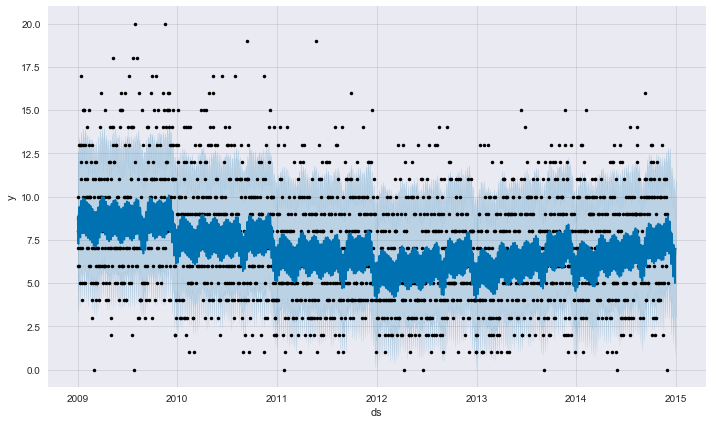

In [36]:
fig = promodel.plot(forecast_python)

In [37]:
predict = list(forecast_python['yhat'][(len(forecast_python)-30):len(forecast_python)])

In [38]:
rmse = np.sqrt(mean_squared_error(np.array(reset['y'][(len(reset)-30):len(reset)]), 
                         np.array(predict)))

In [39]:
rmse

3.1903098597122312

In [40]:
#Our results is not much better.

### trying another city

In [515]:
manchester = accidents[accidents['Local_Authority_(District)'] == 102]

In [516]:
manchester.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year,Month,Hour,count
86470,201206A055688,-2.241210,53.474607,6,2,1,1,06/01/2012,6,16:00,102,E08000003,4,6469,6,30,3,34,0.0,5.0,1,1.0,1.0,0.0,0.0,1,1.0,E01005127,2012,1,16,1
86471,201206A055753,-2.178353,53.521315,6,2,1,1,03/01/2012,3,20:15,102,E08000003,4,6393,3,30,6,0,0.0,0.0,4,5.0,2.0,0.0,0.0,1,1.0,E01005252,2012,1,20,1
86472,201206A055755,-2.197913,53.491648,6,3,2,3,04/01/2012,4,19:10,102,E08000003,5,0,6,30,5,0,0.0,0.0,4,5.0,2.0,0.0,0.0,1,1.0,E01005257,2012,1,19,1
86473,201206A055758,-2.242467,53.517903,6,3,2,1,03/01/2012,3,07:35,102,E08000003,5,0,6,30,-1,0,0.0,0.0,4,5.0,2.0,0.0,0.0,1,1.0,E01005165,2012,1,7,1
86474,201206A055761,-2.237585,53.497257,6,3,1,1,02/01/2012,2,14:00,102,E08000003,3,665,6,30,6,0,0.0,5.0,1,1.0,1.0,4.0,0.0,1,1.0,E01005147,2012,1,14,1


In [517]:
manchestertime = manchester.groupby(['Date']).count().reset_index()

In [519]:
manchestertime = manchestertime[['Date','Day_of_Week']]
manchestertime = manchestertime.rename({'Day_of_Week':'Number_of_Accidents'}, axis = 1)

In [521]:
manchestertime['Date'] = pd.to_datetime(manchestertime['Date'])

manchestertime = manchestertime.sort_values(by='Date')

manchesterts = manchestertime.set_index('Date')

In [522]:
manchesterts

,Number_of_Accidents
Date,
2005-01-01,7
2005-01-02,8
2005-01-03,7
2005-01-04,7
2005-01-05,3
2005-01-06,8
2005-01-07,6
2005-01-08,7
2005-01-09,5


In [524]:
manchesterts.describe()

,Number_of_Accidents
count,3180.000000
mean,4.360377
std,2.506425
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,15.000000


In [525]:
manchesterts9 = manchesterts['2009':'2014']

manreset = manchesterts9.reset_index()

prev_date = manreset.Date[0]
fill = []
for i, row in manreset.iterrows():
    if row.Date != prev_date + datetime.timedelta(days=1):
        fill.append(row.Date - datetime.timedelta(days=1))
    prev_date = row.Date

filldf = pd.DataFrame(fill)
filldf['Number_of_Accidents'] = 0

filldf = filldf.rename({0:'Date'}, axis = 1)

filldf = filldf.drop(index=0)

In [530]:
manreset2 = manreset.append(filldf)

manreset2 = manreset2.sort_values('Date')

In [532]:
manreset2

,Date,Number_of_Accidents
0,2009-01-01,5
1,2009-01-02,3
2,2009-01-03,4
3,2009-01-04,2
4,2009-01-05,13
5,2009-01-06,5
6,2009-01-07,2
7,2009-01-08,2
8,2009-01-09,10
9,2009-01-10,3


In [534]:
manchesterts9 = manreset2.set_index('Date')

In [541]:
accident_series = pd.Series(manchesterts9['Number_of_Accidents'])

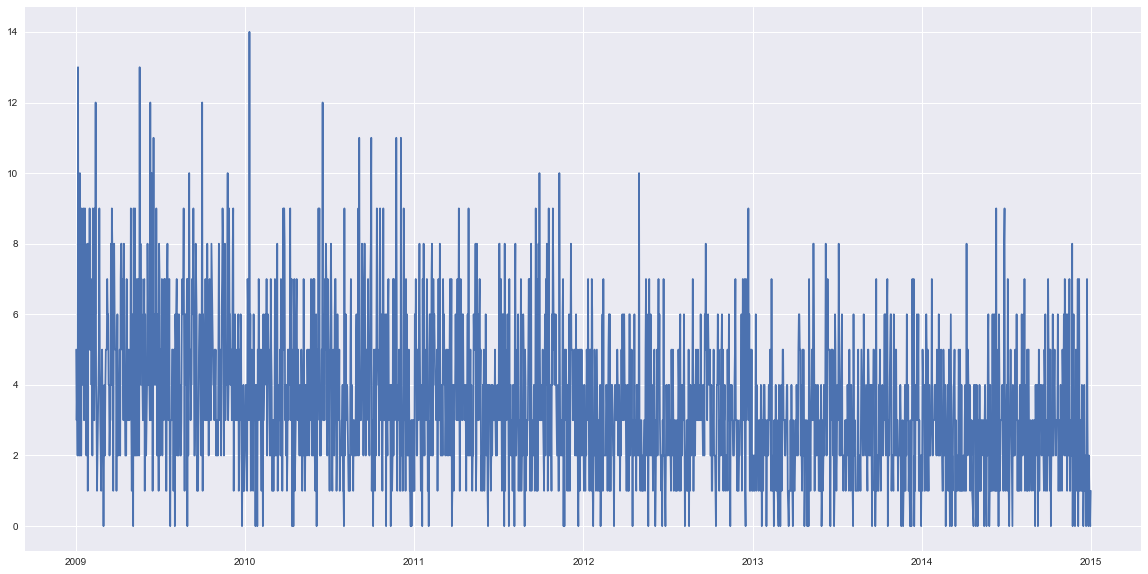

In [542]:
plt.figure(figsize = (20,10))
plt.plot(accident_series)

In [543]:
result = adfuller(accident_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.303163
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


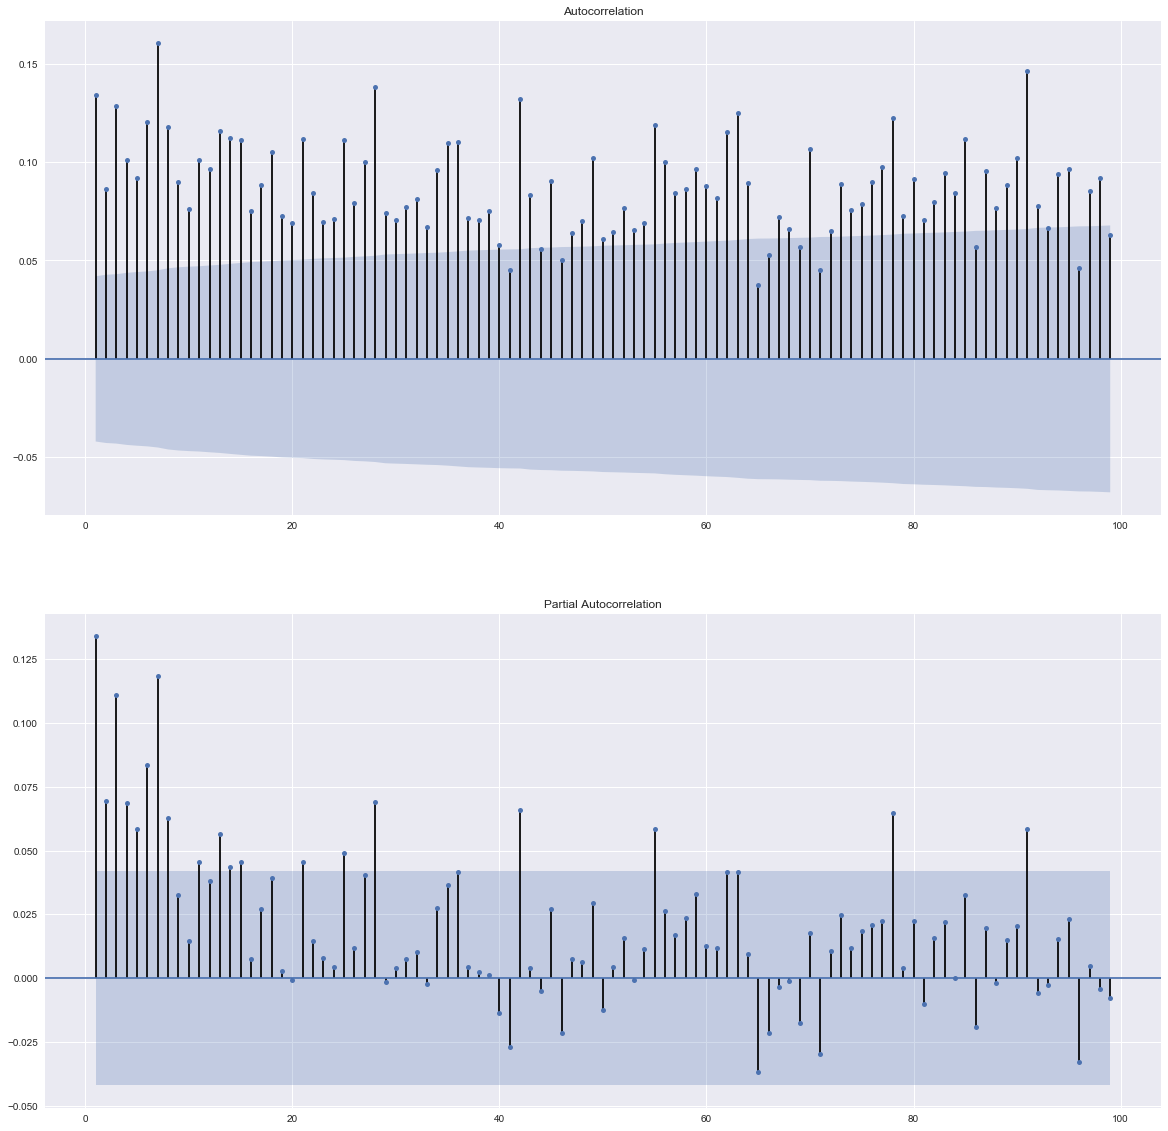

In [544]:
plt.figure(figsize = (20,20))
plt.subplot(211)
plot_acf(accident_series, ax=plt.gca(), lags = np.arange(1,100))
plt.subplot(212)
plot_pacf(accident_series, ax=plt.gca(), lags = np.arange(1,100))
plt.show()

In [545]:
stationary = difference(accident_series)

stationary.index = accident_series.index[1:]

In [546]:
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -15.603429
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


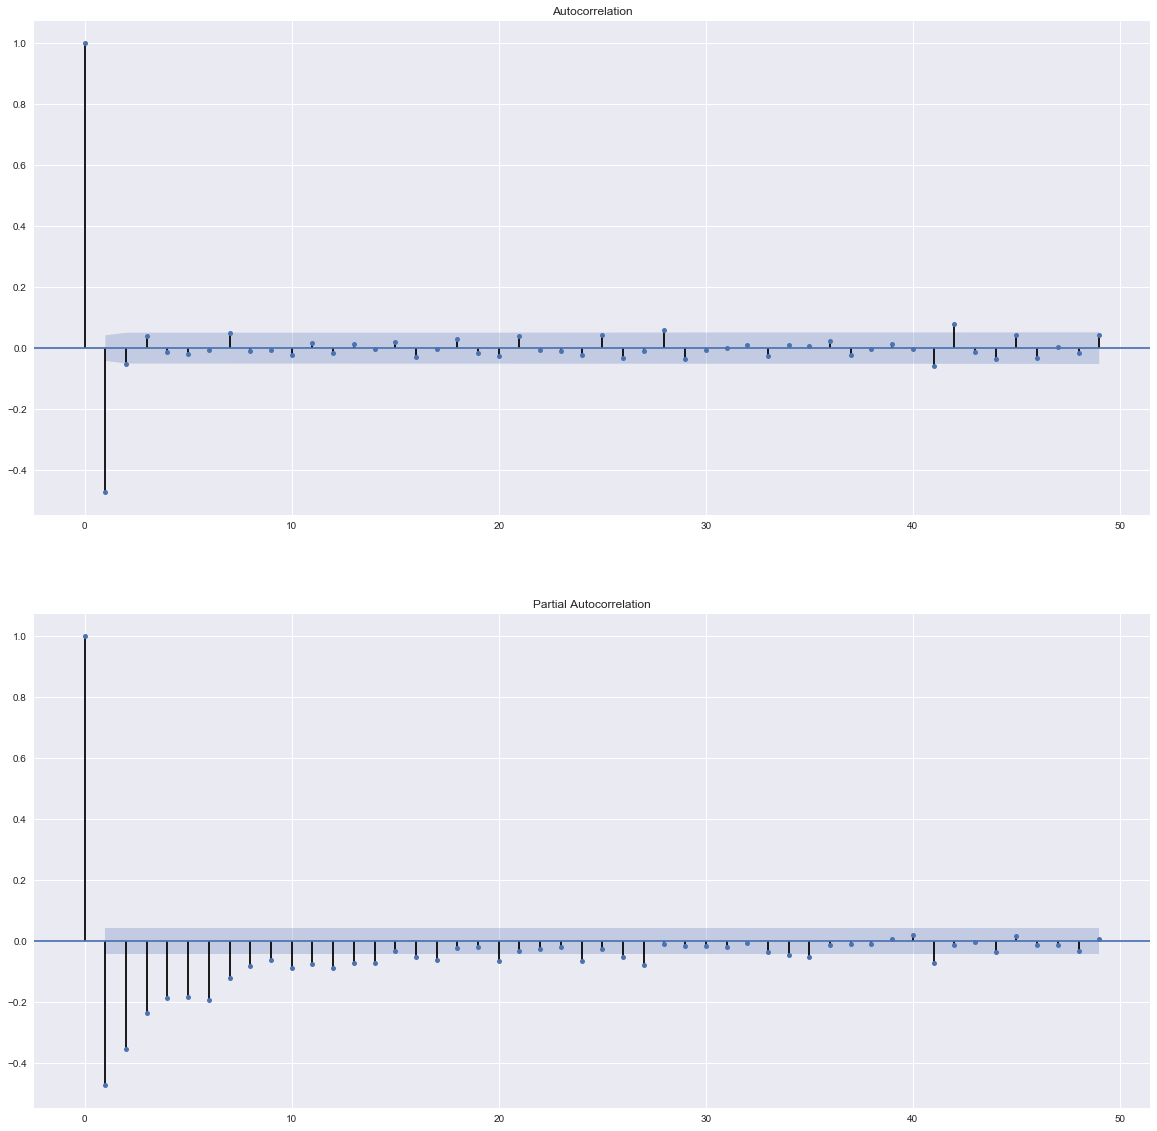

In [547]:
#diff
plt.figure(figsize = (20,20))
plt.subplot(211)
plot_acf(stationary, ax=plt.gca(), lags = np.arange(0,50))
plt.subplot(212)
plot_pacf(stationary, ax=plt.gca(), lags = np.arange(0,50))
plt.show()

In [548]:
accident_series = accident_series.astype('float')

RMSE: 2.105


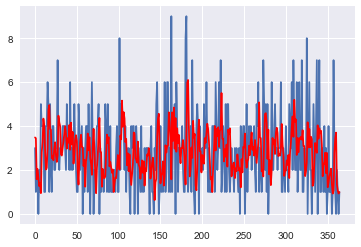

In [549]:
X = accident_series.values
train, test = X[0:(len(X)-365)], X[(len(X)-365):len(X)]
history = [x for x in train]
predictions = []
for i in range(len(test)):
    model = ARIMA(history, order = (2,1,0))
    model_fit = model.fit(disp = 0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%3.f, Expected=%3.f' % (yhat, obs))

mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [550]:
r2_score(test,predictions)

-0.34446282769812631

In [41]:
#Ouch.. negative r^2.. let's think of something else we can do.

## Here, I completely rethought the modelling process.  I wanted to find average weather/light/road conditions to make daily accident count predictions.

### WEATHER engineering

In [5]:
birmingham['Year'].value_counts()

2005    4084
2007    3820
2006    3809
2009    3289
2010    2876
2014    2628
2011    2508
2013    2445
2012    2216
Name: Year, dtype: int64

In [6]:
new_weather_dict = {2:3, 3:5, 4:2, 5:4, 7:1.36, 8:1.36, 9:1.36}

In [7]:
birmingham['Weather_Conditions'].replace(new_weather_dict, inplace = True)

/Users/djurk/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [8]:
birmingham['Weather_Conditions'].value_counts()

1.00    20690
3.00     3514
1.36     2680
2.00      288
4.00      288
5.00      198
6.00       17
Name: Weather_Conditions, dtype: int64

In [9]:
birmingham.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,Year,Month,Hour,count
101387,201220N001882,-1.844921,52.521338,20,2,1,1,02/01/2012,2,22:18,300,E08000025,3,5127,6,30,6,0,0.0,4.0,4,1.0,1.0,0.0,0.0,1,1.0,E01009013,2012,1,22,1
101388,201220N001902,-1.790026,52.535728,20,3,2,1,04/01/2012,4,17:56,300,E08000025,6,0,6,30,-1,0,0.0,4.0,4,3.0,2.0,0.0,0.0,1,1.0,E01009440,2012,1,17,1
101389,201220N003342,-1.790843,52.519007,20,2,2,1,10/01/2012,3,14:40,300,E08000025,6,0,6,30,-1,0,0.0,0.0,1,1.0,1.0,0.0,0.0,1,0.0,E01009099,2012,1,14,1
101390,201220N003352,-1.826506,52.556823,20,2,1,1,14/01/2012,7,02:39,300,E08000025,3,5127,6,30,6,0,0.0,0.0,4,1.0,2.0,0.0,0.0,1,1.0,E01009449,2012,1,2,1
101391,201220N003872,-1.799255,52.516505,20,3,2,2,03/01/2012,3,14:00,300,E08000025,3,452,3,30,3,47,0.0,5.0,1,1.0,1.0,0.0,0.0,1,0.0,E01009101,2012,1,14,1


In [559]:
len(birmingham)

27675

In [10]:
birmingham[birmingham['Weather_Conditions']<7]['Weather_Conditions'].mean()

1.3621246612466524

### light engineering

In [11]:
birmingham['Light_Conditions'].value_counts()

1    19769
4     7576
7      166
5      114
6       50
Name: Light_Conditions, dtype: int64

In [12]:
new_light_dict = {4:2, 5:3, 6:4, 7:1.85}

In [13]:
birmingham['Light_Conditions'].replace(new_light_dict, inplace = True)

/Users/djurk/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [14]:
birmingham['Light_Conditions'].value_counts()

1.00    19769
2.00     7576
1.85      166
3.00      114
4.00       50
Name: Light_Conditions, dtype: int64

### road engineering

In [15]:
birmingham['Road_Surface_Conditions'].value_counts()

1.0    19286
2.0     7787
4.0      438
3.0      151
5.0       13
Name: Road_Surface_Conditions, dtype: int64

In [588]:
#no need, values make sense

# dataframe finished

In [16]:
birminghamdf = birmingham[['Date','Light_Conditions','Weather_Conditions','Road_Surface_Conditions']]


In [17]:
birminghamdf

,Date,Light_Conditions,Weather_Conditions,Road_Surface_Conditions
101387,02/01/2012,2.00,1.00,1.0
101388,04/01/2012,2.00,3.00,2.0
101389,10/01/2012,1.00,1.00,1.0
101390,14/01/2012,2.00,1.00,2.0
101391,03/01/2012,1.00,1.00,1.0
101392,11/01/2012,1.00,1.00,1.0
101393,14/01/2012,2.00,1.00,2.0
101394,24/01/2012,1.00,3.00,2.0
101395,16/01/2012,1.00,1.00,1.0
101396,15/01/2012,1.00,1.36,1.0


In [18]:
birminghamdf['Date'] = pd.to_datetime(birminghamdf['Date'])

/Users/djurk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
birminghammodel = birminghamdf.sort_values(by = 'Date').groupby(['Date']).count()

In [20]:

birminghammodel.rename({'Light_Conditions':'Number_of_Accidents'})

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions
Date,,,
2005-01-01,8,8,8
2005-01-02,16,16,16
2005-01-03,12,12,12
2005-01-04,3,3,3
2005-01-05,12,12,12
2005-01-06,13,13,13
2005-01-07,12,12,12
2005-01-08,11,11,11
2005-01-09,8,8,8


In [21]:
birminghammodel['Count'] = birminghammodel['Light_Conditions']

In [22]:
birminghammodel['Light_Conditions'] = birminghamdf.groupby(['Date']).mean()['Light_Conditions']
birminghammodel['Weather_Conditions'] = birminghamdf.groupby(['Date']).mean()['Weather_Conditions']
birminghammodel['Road_Surface_Conditions'] = birminghamdf.groupby(['Date']).mean()['Road_Surface_Conditions']

In [23]:
birminghammodel

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Count
Date,,,,
2005-01-01,1.750000,1.295000,1.250000,8
2005-01-02,1.375000,1.125000,1.062500,16
2005-01-03,1.500000,1.060000,1.666667,12
2005-01-04,1.333333,1.000000,1.000000,3
2005-01-05,1.000000,1.060000,1.083333,12
2005-01-06,1.000000,2.230769,1.769231,13
2005-01-07,1.083333,1.166667,1.250000,12
2005-01-08,1.000000,1.000000,1.000000,11
2005-01-09,1.125000,1.375000,1.250000,8


In [24]:
birminghammodel.mean()

Light_Conditions           1.302125
Weather_Conditions         1.350361
Road_Surface_Conditions    1.340869
Count                      8.442648
dtype: float64

In [25]:
birminghammodel9 = birminghammodel['2009':'2014']

birmreset = birminghammodel9.reset_index()

prev_date = birmreset.Date[0]
fill = []
for i, row in birmreset.iterrows():
    if row.Date != prev_date + datetime.timedelta(days=1):
        fill.append(row.Date - datetime.timedelta(days=1))
    prev_date = row.Date

filldf = pd.DataFrame(fill)
filldf['Light_Conditions'] = 0
filldf['Weather_Conditions'] = 0
filldf['Road_Surface_Conditions'] = 0
filldf['Count'] = 0

filldf = filldf.rename({0:'Date'}, axis = 1)

filldf = filldf.drop(index=0)

In [26]:
finalbirm = birmreset.append(filldf)

finalbirm = birmreset2.sort_values('Date')

NameError: name 'birmreset2' is not defined

In [27]:
filldf

,Date,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Count
1,2009-03-02,0,0,0,0
2,2009-07-26,0,0,0,0
3,2011-01-27,0,0,0,0
4,2012-04-11,0,0,0,0
5,2012-06-17,0,0,0,0
6,2013-09-06,0,0,0,0
7,2014-05-30,0,0,0,0
8,2014-11-29,0,0,0,0


In [28]:
finalbirm['Light_Conditions'].replace({0:1.302125}, inplace = True)
finalbirm['Weather_Conditions'].replace({0:1.350361}, inplace = True)
finalbirm['Road_Surface_Conditions'].replace({0:1.340869}, inplace = True)

In [29]:
finalbirm = finalbirm.set_index('Date')

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x134bf6198>>
Traceback (most recent call last):
  File "/Users/djurk/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 368, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


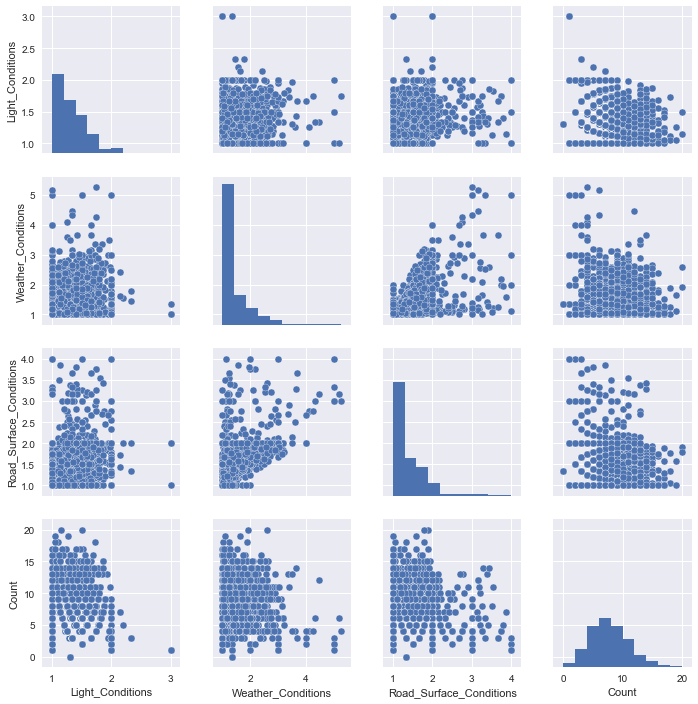

In [685]:
sns.pairplot(finalbirm)

## modelling

In [65]:
sns.set_style('whitegrid')

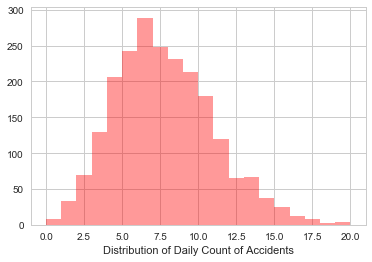

In [66]:
sns.distplot(finalbirm['Count'], kde=False, axlabel = 'Distribution of Daily Count of Accidents', bins = 20, color = 'r')

(array([  41.,  199.,  448.,  537.,  445.,  300.,  132.,   62.,   20.,    7.]),
 array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.]),
 <a list of 10 Patch objects>)

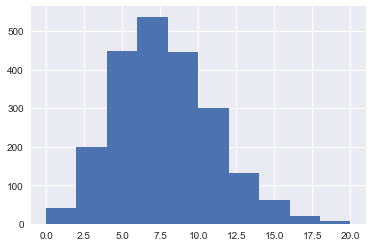

In [33]:
plt.hist(finalbirm['Count'],label = finalbirm['Count'])

In [763]:
y = finalbirm['Count']
X = finalbirm.drop(['Count'], axis = 1)

In [811]:
finalbirm.describe()

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Count
count,2191.000000,2191.000000,2191.000000,2191.000000
mean,1.303714,1.364110,1.360283,7.285258
std,0.264373,0.548116,0.464672,3.251464
min,1.000000,1.000000,1.000000,0.000000
25%,1.111111,1.000000,1.000000,5.000000
50%,1.250000,1.090000,1.200000,7.000000
75%,1.500000,1.544000,1.583333,9.000000
max,3.000000,5.250000,4.000000,20.000000


In [764]:
X.head()

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions
Date,,,
2009-01-01,1.875000,1.225,2.750000
2009-01-02,1.333333,1.000,1.166667
2009-01-03,1.500000,1.000,1.000000
2009-01-04,1.285714,1.000,1.000000
2009-01-05,1.000000,1.180,1.000000


In [765]:
#testing randomforest 
rmses = []
r2s = []
kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(X,y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    tree = RandomForestRegressor(n_estimators = 1000)
    tree.fit(X_train, y_train)
    treepred = tree.predict(X_val)
    
    mse = mean_squared_error(y_val, treepred)
    rmse = np.sqrt(mse)
    print('RMSE: %.3f' % rmse)
    r2 = r2_score(y_val, treepred)
    print('R2 score: %.3f' % r2)
    
    rmses.append(rmse)
    r2s.append(r2)
    
print('\nMEAN RMSE: %.3f' % np.mean(rmses))
print('MEAN R2: %.3f' % np.mean(r2s))
    

RMSE: 3.077
R2 score: 0.258
RMSE: 2.112
R2 score: 0.531
RMSE: 2.016
R2 score: 0.492
RMSE: 2.134
R2 score: 0.464

MEAN RMSE: 2.335
MEAN R2: 0.436


In [809]:
boostpred

array([  6.04926825,   4.72560406,   5.89841509,   9.64956665,
         5.52525473,  12.35984135,   7.53222752,   3.91308522,
         6.72991753,  13.99980354,  12.2460804 ,  11.87629795,
         7.21541452,   8.33069134,   4.40361595,   4.89600897,
        11.81204319,   6.18164492,   3.69562864,   0.96863818,
         2.89242721,   5.29811335,  10.29952812,   4.39219379,
         3.79112744,   7.74524546,   4.86673021,   6.51840258,
         5.53040838,  11.34132767], dtype=float32)

In [814]:
list(zip(boost.feature_importances_,X.columns))

[(0.3272453, 'Light_Conditions'),
 (0.40981132, 'Weather_Conditions'),
 (0.26294339, 'Road_Surface_Conditions')]

In [820]:
rmses = []
r2s = []
kf = KFold(n_splits = 4)
for train_index, test_index in kf.split(X,y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    boost = xgb.XGBRegressor(n_estimators = 1000)
    boost.fit(X_train, y_train)
    boostpred = boost.predict(X_val)
    
    mse = mean_squared_error(y_val, boostpred)
    rmse = np.sqrt(mse)
    print('RMSE: %.3f' % rmse)
    r2 = r2_score(y_val, boostpred)
    print('R2 score: %.3f' % r2)
    
    rmses.append(rmse)
    r2s.append(r2)
    
print('\nMEAN RMSE: %.3f' % np.mean(rmses))
print('MEAN R2: %.3f' % np.mean(r2s))
    

RMSE: 2.868
R2 score: 0.355
RMSE: 1.970
R2 score: 0.592
RMSE: 1.847
R2 score: 0.574
RMSE: 1.956
R2 score: 0.550

MEAN RMSE: 2.160
MEAN R2: 0.518


In [846]:
#Testing xgboost
for i in np.arange(100,1200,100):
    rmses = []
    r2s = []
    kf = KFold(n_splits = 4)
    for train_index, test_index in kf.split(X,y):
        X_train, X_val = X.iloc[train_index], X.iloc[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        boost = xgb.XGBRegressor(n_estimators = 1000, max_depth = 3, subsample = 0.7, min_child_weight = 1,
                                colsample_bytree = 0.9, learning_rate= 0.09)
        boost.fit(X_train, y_train)
        boostpred = boost.predict(X_val)
        mse = mean_squared_error(y_val, boostpred)
        rmse = np.sqrt(mse)
        print('RMSE: %.3f' % rmse)
        r2 = r2_score(y_val, boostpred)
        print('R2 score: %.3f' % r2)

        rmses.append(rmse)
        r2s.append(r2)

    print('\nmax_depth = {}'.format(i))
    print('MEAN RMSE: %.3f' % np.mean(rmses))
    print('MEAN R2: %.3f\n' % np.mean(r2s))
    

RMSE: 3.230
R2 score: 0.182
RMSE: 2.231
R2 score: 0.476
RMSE: 2.234
R2 score: 0.377
RMSE: 2.175
R2 score: 0.443

max_depth = 100
MEAN RMSE: 2.468
MEAN R2: 0.369

RMSE: 3.029
R2 score: 0.281
RMSE: 2.088
R2 score: 0.541
RMSE: 2.023
R2 score: 0.488
RMSE: 2.046
R2 score: 0.508

max_depth = 200
MEAN RMSE: 2.297
MEAN R2: 0.454

RMSE: 2.966
R2 score: 0.310
RMSE: 2.028
R2 score: 0.567
RMSE: 1.950
R2 score: 0.525
RMSE: 1.980
R2 score: 0.539

max_depth = 300
MEAN RMSE: 2.231
MEAN R2: 0.485

RMSE: 2.913
R2 score: 0.335
RMSE: 1.996
R2 score: 0.581
RMSE: 1.894
R2 score: 0.552
RMSE: 1.953
R2 score: 0.551

max_depth = 400
MEAN RMSE: 2.189
MEAN R2: 0.505

RMSE: 2.885
R2 score: 0.348
RMSE: 1.971
R2 score: 0.591
RMSE: 1.866
R2 score: 0.565
RMSE: 1.943
R2 score: 0.556

max_depth = 500
MEAN RMSE: 2.166
MEAN R2: 0.515

RMSE: 2.868
R2 score: 0.355
RMSE: 1.946
R2 score: 0.601
RMSE: 1.835
R2 score: 0.579
RMSE: 1.934
R2 score: 0.560

max_depth = 600
MEAN RMSE: 2.146
MEAN R2: 0.524

RMSE: 2.854
R2 score: 0.362


In [898]:
X_train, X_test = X[0:(len(X)-31)], X[(len(X)-31):len(X)]
y_train, y_test = y[0:(len(y)-31)], y[(len(y)-31):len(y)]

In [899]:
#xgboost did better, so i tuned it
boost = xgb.XGBRegressor(n_estimators = 1000, max_depth = 3, subsample = 0.7, min_child_weight = 1,
                            colsample_bytree = 0.9, learning_rate= 0.09)
boost.fit(X_train, y_train)
boostpred = boost.predict(X_test)

mse = mean_squared_error(y_test, boostpred)
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)
r2 = r2_score(y_test, boostpred)
print('R2 score: %.3f' % r2)

RMSE: 1.827
R2 score: 0.666


In [901]:
boost = pd.DataFrame(y_test)
boost['Count'] = boostpred

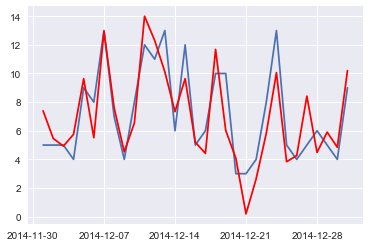

In [902]:
plt.plot(y_test)
plt.plot(boost, color='red')

In [42]:
#Our RMSE was 1.8 and R2 was 0.67, but after thinking about it I realized that my model was just overfitting 
#to exact light/weather/road condition values.
#So in the end, I don't think I created a useful predictive model for predicting counts of accidents.


In [745]:
finalbirm.describe()

,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Count
count,2191.000000,2191.000000,2191.000000,2191.000000
mean,1.303714,1.364110,1.360283,7.285258
std,0.264373,0.548116,0.464672,3.251464
min,1.000000,1.000000,1.000000,0.000000
25%,1.111111,1.000000,1.000000,5.000000
50%,1.250000,1.090000,1.200000,7.000000
75%,1.500000,1.544000,1.583333,9.000000
max,3.000000,5.250000,4.000000,20.000000
